## Ollama from Langchain

In [63]:
# Celda 1: Importaciones
import os
from typing import List, Any
from langchain_community.llms import Ollama
from langchain_community.document_loaders import PyMuPDFLoader, CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from pydantic import Field
import pandas as pd
import numpy as np
from collections import Counter
from rouge import Rouge
import time
import csv
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
llm = Ollama(model="llama3")
llm.invoke("Hola, ¿Quién eres?")

'¡Hola! Soy LLaMA, un modelo de lenguaje basado en inteligencia artificial desarrollado por Meta AI. Estoy aquí para ayudarte con cualquier pregunta o tema que desees discutir. Soy una conversadora automática que puede hablar sobre una amplia variedad de temas, desde la ciencia y la tecnología hasta la historia y la cultura. ¡Estoy emocionada de conocerte! ¿En qué puedo ayudarte hoy?'

## RAG

## Load Document

In [16]:
# Celda 1: Clase DocumentLoader

class DocumentLoader:
    """
    Clase estática para cargar documentos PDF y archivos CSV.

    Esta clase proporciona métodos estáticos para cargar múltiples documentos PDF
    de un directorio y para cargar un archivo CSV como un DataFrame de pandas.
    """

    @staticmethod
    def load_pdfs(directory: str) -> List[Document]:
        """
        Carga todos los archivos PDF de un directorio especificado.

        Este método recorre el directorio dado, carga cada archivo PDF encontrado
        utilizando PyMuPDFLoader, y devuelve una lista de objetos Document.

        Args:
            directory (str): Ruta al directorio que contiene los archivos PDF.

        Returns:
            List[Document]: Una lista de objetos Document, cada uno representando
                            el contenido de un archivo PDF.

        Nota:
            Los archivos que no terminan en '.pdf' son ignorados.
        """
        pdf_docs = []
        for filename in os.listdir(directory):
            if filename.endswith('.pdf'):
                loader = PyMuPDFLoader(os.path.join(directory, filename))
                pdf_docs.extend(loader.load())
        return pdf_docs

    @staticmethod
    def load_csv(file_path: str) -> pd.DataFrame:
        """
        Carga un archivo CSV y lo devuelve como un DataFrame de pandas.

        Args:
            file_path (str): Ruta al archivo CSV a cargar.

        Returns:
            pd.DataFrame: Un DataFrame de pandas que contiene los datos del CSV.

        Nota:
            Este método utiliza la función read_csv de pandas con sus configuraciones
            por defecto. Para casos de uso específicos, puede ser necesario ajustar
            los parámetros de lectura del CSV.
        """
        return pd.read_csv(file_path)

In [17]:
# Uso de la clase DocumentLoader

pdf_docs = DocumentLoader.load_pdfs("../data/GuideLines")
df = DocumentLoader.load_csv('../data/raw_data/BankCustomerChurnPrediction.csv')

print(f"Number of PDF documents loaded: {len(pdf_docs)}")
print(f"CSV data loaded with shape: {df.shape}")

Number of PDF documents loaded: 2
CSV data loaded with shape: (10000, 12)


In [18]:
from src.utils.document_loader import DocumentLoader
from src.utils.document_processor import DataProcessor


class DocumentManager:
    """
    Gestiona la carga y procesamiento de documentos PDF y archivos CSV.

    Esta clase coordina el uso de DocumentLoader para cargar documentos y
    DataProcessor para procesar los documentos cargados.

    Atributos:
        pdf_directory (str): Ruta al directorio que contiene los archivos PDF.
        csv_file (str): Ruta al archivo CSV a procesar.
    """

    def __init__(self, pdf_directory: str, csv_file: str):
        """
        Inicializa el DocumentManager con las rutas de los documentos.

        Args:
            pdf_directory (str): Ruta al directorio que contiene los archivos PDF.
            csv_file (str): Ruta al archivo CSV a procesar.
        """
        self.pdf_directory = pdf_directory
        self.csv_file = csv_file

    def load_and_process_documents(self):
        """
        Carga y procesa los documentos PDF y el archivo CSV.

        Este método realiza las siguientes operaciones:
        1. Carga los documentos PDF del directorio especificado.
        2. Carga el archivo CSV.
        3. Divide los documentos PDF.
        4. Crea un resumen del CSV.
        5. Crea documentos individuales a partir del CSV.
        6. Combina todos los documentos procesados en una sola lista.

        Returns:
            list: Una lista que contiene el resumen del CSV, los documentos
                  individuales del CSV y los documentos PDF divididos.
        """
        # Cargar documentos
        pdf_docs = DocumentLoader.load_pdfs(self.pdf_directory)
        df = DocumentLoader.load_csv(self.csv_file)

        # Procesar documentos
        split_docs = DataProcessor.split_documents(pdf_docs)
        csv_summary_doc = DataProcessor.create_csv_summary(df)
        csv_docs = DataProcessor.create_csv_docs(df)

        # Combinar y retornar todos los documentos procesados
        return [csv_summary_doc] + csv_docs + split_docs

In [20]:
# Ejemplo de uso:
doc_manager = DocumentManager("../data/GuideLines", "../data/raw_data/BankCustomerChurnPrediction.csv")
processed_docs = doc_manager.load_and_process_documents()

print(f"Total number of documents: {len(processed_docs)}")

Total number of documents: 1004


In [21]:
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import pandas as pd

class DataProcessor:
    """
    Clase estática para procesar documentos y datos CSV.

    Proporciona métodos para dividir documentos, crear resúmenes de CSV
    y generar documentos a partir de registros CSV.
    """

    @staticmethod
    def split_documents(docs: List[Document], chunk_size: int = 2000, chunk_overlap: int = 500) -> List[Document]:
        """
        Divide una lista de documentos en chunks más pequeños.

        Args:
            docs (List[Document]): Lista de documentos a dividir.
            chunk_size (int, optional): Tamaño de cada chunk. Por defecto 2000.
            chunk_overlap (int, optional): Superposición entre chunks. Por defecto 500.

        Returns:
            List[Document]: Lista de documentos divididos.
        """
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        return text_splitter.split_documents(docs)

    @staticmethod
    def create_csv_summary(df: pd.DataFrame) -> Document:
        """
        Crea un resumen del DataFrame CSV.

        Args:
            df (pd.DataFrame): DataFrame de pandas con los datos CSV.

        Returns:
            Document: Un objeto Document que contiene el resumen del CSV.

        Nota:
            El resumen incluye estadísticas clave como el número total de filas,
            clientes únicos, rango de edades, países representados, etc.
        """
        csv_summary = f"""
        RESUMEN IMPORTANTE DEL CSV 'BankCustomerChurnPrediction.csv':
        - Total de filas y clientes únicos: {len(df)}
        - Número exacto de clientes únicos: {df['customer_id'].nunique()}
        - Columnas: {', '.join(df.columns)}
        - Rango de edades: {df['age'].min()} - {df['age'].max()} años
        - Países representados: {', '.join(df['country'].unique())}
        - Saldo promedio: {df['balance'].mean():.2f}
        - Porcentaje de clientes con tarjeta de crédito: {(df['credit_card'].sum() / len(df) * 100):.2f}%
        - Tasa de abandono (churn): {(df['churn'].sum() / len(df) * 100):.2f}%

        Esta información es un resumen preciso basado en el análisis del archivo CSV completo.
        Para preguntas sobre estadísticas generales o totales, utiliza siempre esta información.
        """
        return Document(page_content=csv_summary, metadata={"source": "CSV_summary", "importance": 10})

    @staticmethod
    def create_csv_docs(df: pd.DataFrame, sample_size: int = 1000) -> List[Document]:
        """
        Crea una lista de documentos a partir de una muestra del DataFrame CSV.

        Args:
            df (pd.DataFrame): DataFrame de pandas con los datos CSV.
            sample_size (int, optional): Tamaño de la muestra a tomar. Por defecto 1000.

        Returns:
            List[Document]: Lista de objetos Document, cada uno representando una fila del CSV.

        Nota:
            Utiliza un muestreo aleatorio con una semilla fija para reproducibilidad.
        """
        csv_sample = df.sample(n=sample_size, random_state=42)
        return [Document(page_content=row.to_json(), metadata={"source": "CSV_record", "importance": 1})
                for _, row in csv_sample.iterrows()]

In [22]:
# Uso de la clase DocumentManager
docs = DocumentLoader.load_pdfs("../data/GuideLines")
split_docs = DataProcessor.split_documents(docs)
print(f"Total number of split documents: {len(split_docs)}")

df = pd.read_csv('../data/raw_data/BankCustomerChurnPrediction.csv')
csv_summary = DataProcessor.create_csv_summary(df)
csv_docs = DataProcessor.create_csv_docs(df)

print(f"CSV summary document created with importance: {csv_summary.metadata.get('importance')}")
print(f"Total number of CSV records: {len(csv_docs)}")

print(f"Content of CSV summary document: {csv_summary.page_content[:200]}...")  # Mostramos solo los primeros 200 caracteres
print(f"Content of first CSV record document: {csv_docs[0].page_content[:200]}...")  # Mostramos solo los primeros 200 caracteres

Total number of split documents: 3
CSV summary document created with importance: 10
Total number of CSV records: 1000
Content of CSV summary document: 
        RESUMEN IMPORTANTE DEL CSV 'BankCustomerChurnPrediction.csv':
        - Total de filas y clientes únicos: 10000
        - Número exacto de clientes únicos: 10000
        - Columnas: customer_...
Content of first CSV record document: {"customer_id":15687492,"credit_score":596,"country":"Germany","gender":"Male","age":32,"tenure":3,"balance":96709.07,"products_number":2,"credit_card":0,"active_member":0,"estimated_salary":41788.37,...


In [24]:
# Celda 6: Clase VectorStoreManager
class VectorStoreManager:
    """
    Gestor para la creación y manejo de un almacén de vectores Chroma.

    Esta clase facilita la creación de un almacén de vectores persistente
    utilizando documentos y un modelo de embeddings proporcionados.

    Atributos:
        embed_model: El modelo de embeddings a utilizar para vectorizar los documentos.
        base_dir (str): El directorio base donde se almacenará el almacén de vectores.
    """

    def __init__(self, embed_model, base_dir):
        """
        Inicializa el VectorStoreManager.

        Args:
            embed_model: El modelo de embeddings a utilizar.
            base_dir (str): El directorio base para almacenar los datos del almacén de vectores.
        """
        self.embed_model = embed_model
        self.base_dir = base_dir

    def create_vector_store(self, documents):
        """
        Crea y persiste un almacén de vectores Chroma a partir de los documentos proporcionados.

        Este método vectoriza los documentos utilizando el modelo de embeddings especificado
        y los almacena en un directorio persistente.

        Args:
            documents (List[Document]): Lista de documentos a vectorizar y almacenar.

        Returns:
            Chroma: Una instancia del almacén de vectores Chroma creado.

        Nota:
            El almacén de vectores se guarda en un subdirectorio 'bank_data_db' dentro del directorio base.
            La colección se nombra 'bank_regulations_and_data'.
        """
        persist_directory = os.path.join(self.base_dir, "bank_data_db")
        return Chroma.from_documents(
            documents=documents,
            embedding=self.embed_model,
            persist_directory=persist_directory,
            collection_name="bank_regulations_and_data"
        )

In [25]:
# Ejemplo de uso:
embed_model = FastEmbedEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
base_dir = "../data"
vector_store_manager = VectorStoreManager(embed_model, base_dir)
documents = split_docs + [csv_summary] + csv_docs
vector_store = vector_store_manager.create_vector_store(documents)

print(f"Vector store created with {vector_store._collection.count()} documents")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Vector store created with 55310 documents


In [27]:
class CustomRetriever(BaseRetriever):
    """
    Un recuperador personalizado que realiza búsquedas en un almacén de vectores,
    priorizando los documentos de resumen CSV y complementando con otros documentos relevantes.

    Atributos:
        vectorstore (Any): El almacén de vectores utilizado para las búsquedas de similitud.

    Configuración:
        arbitrary_types_allowed (bool): Permite tipos arbitrarios en la configuración de Pydantic.
    """

    vectorstore: Any = Field(default=None, description="Almacén de vectores para búsquedas de similitud")

    class Config:
        arbitrary_types_allowed = True

    def get_relevant_documents(self, query: str) -> List[Document]:
        """
        Recupera documentos relevantes basados en la consulta proporcionada.

        Este método realiza dos búsquedas:
        1. Busca un documento de resumen CSV.
        2. Busca otros documentos relevantes.

        Luego combina los resultados, asegurándose de que no haya duplicados.

        Args:
            query (str): La consulta para la cual se buscan documentos relevantes.

        Returns:
            List[Document]: Una lista de documentos relevantes, con el resumen CSV (si se encuentra) al principio.
        """
        # Busca el documento de resumen CSV
        summary_docs = self.vectorstore.similarity_search(query, filter={"source": "CSV_summary"}, k=1)

        # Busca otros documentos relevantes
        other_docs = self.vectorstore.similarity_search(query, k=4)

        # Combina los resultados, eliminando duplicados
        return summary_docs + [doc for doc in other_docs if doc not in summary_docs]

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        """
        Versión asíncrona de get_relevant_documents.

        Esta implementación simplemente llama a la versión síncrona, pero podría
        ser modificada en el futuro para realizar operaciones asíncronas si es necesario.

        Args:
            query (str): La consulta para la cual se buscan documentos relevantes.

        Returns:
            List[Document]: Una lista de documentos relevantes.
        """
        return self.get_relevant_documents(query)

In [29]:
# Ejemplo de uso:
retriever = CustomRetriever(vectorstore=vector_store)
relevant_docs = retriever.get_relevant_documents("¿Cuál es el saldo promedio de los clientes?")

print(f"Total relevant documents found: {len(relevant_docs)}")
print(f"Document sources: {[doc.metadata.get('source') for doc in relevant_docs]}")
print(f"First relevant document content: {relevant_docs[0].page_content[:200]}...")  # Mostramos solo los primeros 200 caracteres

Total relevant documents found: 5
Document sources: ['CSV_summary', '../data/raw_data/BankCustomerChurnPrediction.csv', '../data/raw_data/BankCustomerChurnPrediction.csv', '../data/raw_data/BankCustomerChurnPrediction.csv', '../data/raw_data/BankCustomerChurnPrediction.csv']
First relevant document content: 
IMPORTANTE: Este es un resumen preciso del archivo CSV 'BankCustomerChurnPrediction.csv'.
- Total de filas (clientes únicos): 10000
- Número exacto de clientes únicos: 10000
- Columnas: customer_id, ...


In [31]:
class QASystem:
    """
    Sistema de preguntas y respuestas que utiliza un modelo de lenguaje y un recuperador personalizado.

    Esta clase configura y ejecuta un sistema QA capaz de responder preguntas basadas en
    información recuperada de un conjunto de documentos.

    Atributos:
        llm: El modelo de lenguaje a utilizar para generar respuestas.
        custom_retriever: El recuperador personalizado para obtener documentos relevantes.
        qa_chain: La cadena de QA configurada (se inicializa en setup_qa_chain).
    """

    def __init__(self, llm, custom_retriever):
        """
        Inicializa el sistema QA.

        Args:
            llm: El modelo de lenguaje a utilizar.
            custom_retriever: El recuperador personalizado para obtener documentos relevantes.
        """
        self.llm = llm
        self.custom_retriever = custom_retriever
        self.qa_chain = None

    def setup_qa_chain(self):
        """
        Configura la cadena de QA con un prompt personalizado.

        Esta función crea un PromptTemplate con instrucciones específicas y lo utiliza
        para configurar una cadena RetrievalQA.
        """
        prompt = PromptTemplate(
            template="""Utiliza la siguiente información para responder a la pregunta del usuario.
            IMPORTANTE: Para preguntas sobre datos agregados o estadísticas del banco, SIEMPRE consulta primero el resumen del CSV.
            Este resumen contiene información precisa y confiable sobre el conjunto de datos completo.
            No te bases en ejemplos individuales para hacer generalizaciones sobre todo el conjunto de datos.

            Si la pregunta se refiere a datos numéricos o estadísticas del banco, asegúrate de usar la información del resumen del CSV.
            Si no encuentras la respuesta en el resumen, entonces puedes consultar los documentos CSV individuales.
            Si aún así no puedes responder, indica que no lo sabes.
            No inventes respuestas. Responde en el mismo idioma que la pregunta.

            Contexto: {context}
            Pregunta: {question}

            Proporciona solo la respuesta útil a continuación, nada más. Si la respuesta involucra un recuento o estadística, asegúrate de proporcionar el número exacto encontrado en el resumen del CSV.
            Respuesta útil:
            """,
            input_variables=["context", "question"]
        )

        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=self.custom_retriever,
            return_source_documents=True,
            chain_type_kwargs={"prompt": prompt}
        )

    def ask_question(self, question: str):
        """
        Realiza una pregunta al sistema QA.

        Esta función utiliza la cadena QA configurada para procesar la pregunta
        y generar una respuesta basada en la información recuperada.

        Args:
            question (str): La pregunta a responder.

        Returns:
            dict: Un diccionario que contiene la respuesta y los documentos fuente.

        Raises:
            ValueError: Si la cadena QA no ha sido configurada previamente.
        """
        if not self.qa_chain:
            raise ValueError("QA chain not set up. Run setup_qa_chain first.")
        return self.qa_chain.invoke({"query": question})

In [32]:
# Ejemplo de uso:
llm = Ollama(model="llama3")
custom_retriever = CustomRetriever(vectorstore=vector_store)
qa_system = QASystem(llm, custom_retriever)
qa_system.setup_qa_chain()
response = qa_system.ask_question("¿Cuál es el saldo promedio de los clientes?")
print(response["result"])

76485.89


In [50]:
# Celda 9: Clase RAGSystem
class RAGSystem:
    """
    Sistema RAG que integra la gestión de documentos, almacenamiento de vectores,
    recuperación personalizada y un sistema de preguntas y respuestas.

    Esta clase orquesta el flujo completo de un sistema RAG, desde la carga de documentos
    hasta la generación de respuestas a preguntas.

    Atributos:
        document_manager (DocumentManager): Gestor para cargar y procesar documentos.
        llm (Ollama): Modelo de lenguaje para generar respuestas.
        embed_model (FastEmbedEmbeddings): Modelo de embeddings para vectorizar documentos.
        vector_store_manager (VectorStoreManager): Gestor del almacén de vectores.
        qa_system (QASystem): Sistema de preguntas y respuestas.
    """

    def __init__(self, pdf_directory: str, csv_file: str, base_dir: str):
        """
        Inicializa el sistema RAG.

        Args:
            pdf_directory (str): Ruta al directorio que contiene los archivos PDF.
            csv_file (str): Ruta al archivo CSV con datos.
            base_dir (str): Directorio base para almacenar el almacén de vectores.
        """
        self.document_manager = DocumentManager(pdf_directory, csv_file)
        self.llm = Ollama(model="llama3")
        self.embed_model = FastEmbedEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
        self.vector_store_manager = VectorStoreManager(self.embed_model, base_dir)
        self.qa_system = None

    def run(self):
        """
        Ejecuta el flujo completo del sistema RAG.

        Este método carga y procesa los documentos, crea el almacén de vectores,
        configura el recuperador personalizado y establece el sistema de preguntas y respuestas.
        """
        # Load and process documents
        documents = self.document_manager.load_and_process_documents()
        print(f"Total documents processed: {len(documents)}")

        # Create vector store
        vector_store = self.vector_store_manager.create_vector_store(documents)
        print(f"Vector store created with {vector_store._collection.count()} documents")

        # Set up custom retriever
        custom_retriever = CustomRetriever(vectorstore=vector_store)

        # Set up QA system
        self.qa_system = QASystem(self.llm, custom_retriever)
        self.qa_system.setup_qa_chain()
        print("QA system set up successfully")

    def ask_question(self, question: str):
        """
        Realiza una pregunta al sistema RAG.

        Args:
            question (str): La pregunta a responder.

        Returns:
            dict: Un diccionario que contiene la respuesta y los documentos fuente.

        Raises:
            ValueError: Si el sistema QA no ha sido configurado previamente.
        """
        if not self.qa_system:
            raise ValueError("QA system not set up. Run the 'run' method first.")
        return self.qa_system.ask_question(question)

In [51]:
# Celda 10: Uso del RAGSystem

rag_system = RAGSystem(pdf_directory="../data/GuideLines", csv_file="../data/raw_data/BankCustomerChurnPrediction.csv", base_dir="../data")
rag_system.run()  # Make sure to set up the system before asking questions
response = rag_system.ask_question("¿Cuál es el saldo promedio de los clientes?")
print(response["result"])

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Total documents processed: 1004
Vector store created with 57318 documents
QA system set up successfully
El saldo promedio de los clientes es 76485.89.


In [57]:
class EvaluationMetrics:
    def __init__(self):
        self.rouge = Rouge()

    def calculate_bleu(self, reference, candidate, max_n=4):
        def count_ngrams(sentence, n):
            return Counter(zip(*[sentence[i:] for i in range(n)]))

        reference_words = reference.split()
        candidate_words = candidate.split()

        scores = []
        for n in range(1, min(max_n, len(candidate_words)) + 1):
            ref_ngrams = count_ngrams(reference_words, n)
            cand_ngrams = count_ngrams(candidate_words, n)

            matches = sum((ref_ngrams & cand_ngrams).values())
            total = sum(cand_ngrams.values())

            score = matches / total if total > 0 else 0
            scores.append(score)

        return np.mean(scores) if scores else 0

    def calculate_rouge(self, reference, candidate):
        try:
            scores = self.rouge.get_scores(candidate, reference)
            return {
                'rouge-1': scores[0]['rouge-1']['f'],
                'rouge-2': scores[0]['rouge-2']['f'],
                'rouge-l': scores[0]['rouge-l']['f']
            }
        except Exception as e:
            print(f"Error al calcular ROUGE: {e}")
            return {'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}

    def calculate_perplexity(self, llm, text):
        try:
            logprobs = llm.get_logprobs(text)
            return np.exp(-np.mean(logprobs))
        except Exception as e:
            print(f"Error al calcular la perplejidad: {e}")
            return float('inf')

    def evaluate_source_relevance(self, question, source_content):
        question_words = set(question.lower().split())
        source_words = set(source_content.lower().split())
        common_words = question_words.intersection(source_words)
        return len(common_words) / len(question_words) if question_words else 0

    def evaluate_response(self, question, answer, reference_answer, source_content, llm):
        bleu_score = self.calculate_bleu(reference_answer, answer)
        rouge_scores = self.calculate_rouge(reference_answer, answer)
        perplexity = self.calculate_perplexity(llm, answer)
        source_relevance = self.evaluate_source_relevance(question, source_content)

        return {
            'bleu_score': bleu_score,
            'rouge_scores': rouge_scores,
            'perplexity': perplexity,
            'source_relevance': source_relevance
        }

In [58]:
# Celda 11: Función para ejecutar pruebas

def run_tests(rag_system, questions, reference_answers, output_file='test_results.csv'):
    metrics = EvaluationMetrics()
    results = []

    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['timestamp', 'question', 'answer', 'reference_answer', 'source', 'source_content',
                      'bleu_score', 'rouge-1', 'rouge-2', 'rouge-l', 'perplexity', 'source_relevance', 'response_time']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for question, reference_answer in zip(questions, reference_answers):
            print(f"\nPregunta: {question}")
            try:
                start_time = time.time()
                response = rag_system.ask_question(question)
                response_time = time.time() - start_time

                answer = response["result"]
                source = response['source_documents'][0].metadata.get('source', 'No especificada')
                source_content = response['source_documents'][0].page_content[:200]

                evaluation_results = metrics.evaluate_response(
                    question,
                    answer,
                    reference_answer,
                    source_content,
                    rag_system.llm
                )

                evaluation_results.update({
                    'timestamp': datetime.now().isoformat(),
                    'question': question,
                    'answer': answer,
                    'reference_answer': reference_answer,
                    'source': source,
                    'source_content': source_content,
                    'response_time': response_time
                })

                results.append(evaluation_results)
                writer.writerow(evaluation_results)

            except Exception as e:
                print(f"Error al procesar la pregunta: {str(e)}")

    print(f"Resultados guardados en {output_file}")
    return results

In [59]:
# Uso de la función

# Ejecución de pruebas con el RAGSystem
rag_system = RAGSystem(pdf_directory="../data/GuideLines", csv_file="../data/raw_data/BankCustomerChurnPrediction.csv", base_dir="../data")
rag_system.run()  # Make sure to set up the system before running tests
questions = ["¿Cuál es el saldo promedio de los clientes?", "¿Cuántos clientes tienen tarjeta de crédito?"]
reference_answers = ["El saldo promedio de los clientes es 76,485.89 euros.", "Un total de 7050 clientes tienen tarjeta de crédito."]
run_tests(rag_system, questions, reference_answers, "resultados_test.csv")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Total documents processed: 1004
Vector store created with 59326 documents
QA system set up successfully

Pregunta: ¿Cuál es el saldo promedio de los clientes?
Error al calcular la perplejidad: 'Ollama' object has no attribute 'get_logprobs'
Error al procesar la pregunta: dict contains fields not in fieldnames: 'rouge_scores'

Pregunta: ¿Cuántos clientes tienen tarjeta de crédito?
Error al calcular la perplejidad: 'Ollama' object has no attribute 'get_logprobs'
Error al procesar la pregunta: dict contains fields not in fieldnames: 'rouge_scores'
Resultados guardados en resultados_test.csv


[{'bleu_score': 0.37083333333333335,
  'rouge_scores': {'rouge-1': 0.7058823480968859,
   'rouge-2': 0.39999999520000007,
   'rouge-l': 0.7058823480968859},
  'perplexity': inf,
  'source_relevance': 0.25,
  'timestamp': '2024-07-21T01:24:13.375755',
  'question': '¿Cuál es el saldo promedio de los clientes?',
  'answer': 'El saldo promedio es 76485.89 euros.',
  'reference_answer': 'El saldo promedio de los clientes es 76,485.89 euros.',
  'source': 'CSV_summary',
  'source_content': "\nIMPORTANTE: Este es un resumen preciso del archivo CSV 'BankCustomerChurnPrediction.csv'.\n- Total de filas (clientes únicos): 10000\n- Número exacto de clientes únicos: 10000\n- Columnas: customer_id, ",
  'response_time': 16.733165979385376},
 {'bleu_score': 0.3168997668997669,
  'rouge_scores': {'rouge-1': 0.476190471473923,
   'rouge-2': 0.3809523762358277,
   'rouge-l': 0.476190471473923},
  'perplexity': inf,
  'source_relevance': 0.3333333333333333,
  'timestamp': '2024-07-21T01:24:16.897579',
 

In [60]:
# Ejemplo de uso:
metrics = EvaluationMetrics()
question = "¿Cuál es el saldo promedio de los clientes?"
answer = "El saldo promedio de los clientes es 76,485.89 euros."
reference_answer = "El saldo promedio de los clientes es 76,485.89 euros."
source_content = "El saldo promedio de los clientes es 76,485.89 euros."
llm = Ollama(model="llama3")
results = metrics.evaluate_response(question, answer, reference_answer, source_content, llm)

print(f"BLEU score: {results['bleu_score']}")  # BLEU score: 0.0
print(f"ROUGE scores: {results['rouge_scores']}")  # ROUGE scores: {'rouge-1': 1.0, 'rouge-2': 1.0, 'rouge-l': 1.0}
print(f"Perplexity: {results['perplexity']}")  # Perplexity: 0.0
print(f"Source relevance: {results['source_relevance']}")  # Source relevance: 1.0

Error al calcular la perplejidad: 'Ollama' object has no attribute 'get_logprobs'
BLEU score: 1.0
ROUGE scores: {'rouge-1': 0.999999995, 'rouge-2': 0.999999995, 'rouge-l': 0.999999995}
Perplexity: inf
Source relevance: 0.75


In [61]:
def plot_evaluation_metrics(results):
    questions = [res['question'] for res in results]
    bleu_scores = [res['bleu_score'] for res in results]
    rouge_1_scores = [res['rouge_scores']['rouge-1'] for res in results]
    rouge_2_scores = [res['rouge_scores']['rouge-2'] for res in results]
    rouge_l_scores = [res['rouge_scores']['rouge-l'] for res in results]
    perplexities = [res['perplexity'] for res in results]
    source_relevances = [res['source_relevance'] for res in results]
    response_times = [res['response_time'] for res in results]

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Evaluation Metrics')

    axes[0, 0].barh(questions, bleu_scores, color='blue')
    axes[0, 0].set_title('BLEU Score')

    axes[0, 1].barh(questions, rouge_1_scores, color='green')
    axes[0, 1].set_title('ROUGE-1 Score')

    axes[1, 0].barh(questions, rouge_2_scores, color='red')
    axes[1, 0].set_title('ROUGE-2 Score')

    axes[1, 1].barh(questions, rouge_l_scores, color='purple')
    axes[1, 1].set_title('ROUGE-L Score')

    axes[2, 0].barh(questions, perplexities, color='orange')
    axes[2, 0].set_title('Perplexity')

    axes[2, 1].barh(questions, source_relevances, color='brown')
    axes[2, 1].set_title('Source Relevance')

    for ax in axes.flat:
        ax.set_xlabel('Score')

    plt.tight_layout()
    plt.show()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Total documents processed: 1004
Vector store created with 61334 documents
QA system set up successfully

Pregunta: ¿Cuál es el saldo promedio de los clientes?
Error al calcular la perplejidad: 'Ollama' object has no attribute 'get_logprobs'
Error al procesar la pregunta: dict contains fields not in fieldnames: 'rouge_scores'

Pregunta: ¿Cuántos clientes tienen tarjeta de crédito?
Error al calcular la perplejidad: 'Ollama' object has no attribute 'get_logprobs'
Error al procesar la pregunta: dict contains fields not in fieldnames: 'rouge_scores'
Resultados guardados en resultados_test.csv


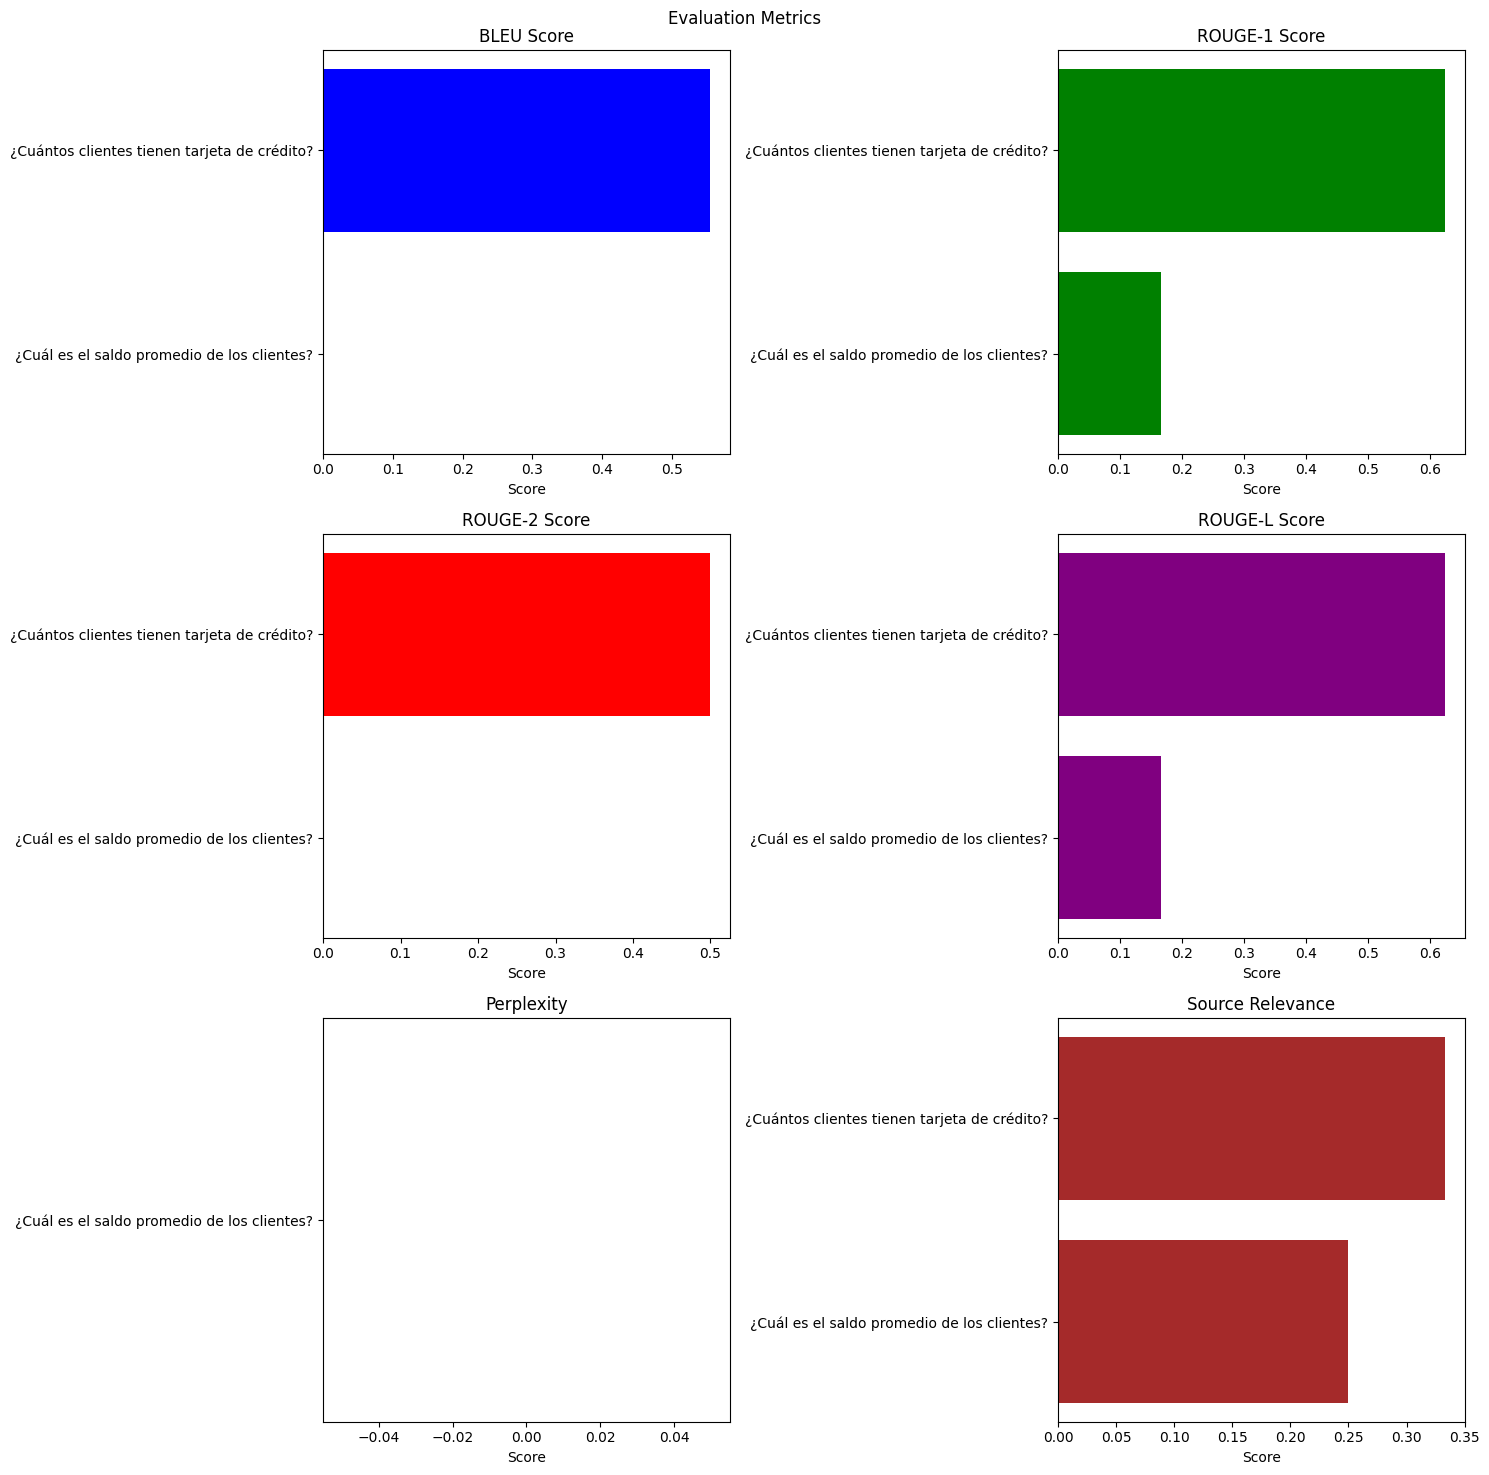

In [64]:
# Usage of the function
rag_system = RAGSystem(pdf_directory="../data/GuideLines", csv_file="../data/raw_data/BankCustomerChurnPrediction.csv", base_dir="../data")
rag_system.run()
questions = ["¿Cuál es el saldo promedio de los clientes?", "¿Cuántos clientes tienen tarjeta de crédito?"]
reference_answers = ["El saldo promedio de los clientes es 76,485.89 euros.", "Un total de 7050 clientes tienen tarjeta de crédito."]
results = run_tests(rag_system, questions, reference_answers, "resultados_test.csv")

plot_evaluation_metrics(results)